In [17]:
from tensorflow.keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt


In [19]:
# 1. 데이터 생성하기
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.7,
                                   zoom_range=[0.9, 2.2],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(32, 32),
        batch_size=3,
        class_mode='binary') 

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(32, 32),     
        batch_size=3,
        class_mode='binary')

Found 974 images belonging to 2 classes.
Found 239 images belonging to 2 classes.


In [30]:
# 2. 모델 구성하기
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='elu', input_shape=(32,32, 3)))
model.add(Conv2D(32, (3, 3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid')) 


# 3. 모델 학습과정 설정하기
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001)
#                  ,loss=tf.keras.losses.binary_crossentropy
#                  ,metrics=[tf.keras.metrics.Precision(name='precision')\
#                           ,tf.keras.metrics.Recall(name='recall')\
#                           ,tf.keras.metrics.FalsePositives(name='false_positives')\
#                           ,tf.keras.metrics.FalseNegatives(name='false_negatives')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1score])

early_stopping = EarlyStopping(patience=10) # 조기종료 콜백함수 정의

# 4. 모델 학습시키기
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=50, 
        epochs=50,  
        validation_data=test_generator,
        validation_steps=5,
        callbacks=[early_stopping]
        ) 

_loss, _acc, _precision, _recall, _f1score = model.evaluate_generator(test_generator, steps=5)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))


# # 5. 모델 평가하기
# print("-- Evaluate --")
# scores = model.evaluate_generator(test_generator, steps=5)
# print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# # 6. 모델 사용하기
# print("-- Predict --")
# output = model.predict_generator(test_generator, steps=5)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# print(test_generator.class_indices)
# print(output)

Epoch 1/50
50/50 [==============================] - 2s 39ms/step - loss: 0.8752 - accuracy: 0.5000 - precision: 0.2267 - recall: 0.3667 - f1score: 0.2627 - val_loss: 0.7572 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.6000 - val_f1score: 0.4000
Epoch 2/50
50/50 [==============================] - 2s 40ms/step - loss: 0.7365 - accuracy: 0.5933 - precision: 0.3600 - recall: 0.4100 - f1score: 0.3513 - val_loss: 0.9052 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.6000 - val_f1score: 0.4000
Epoch 3/50
50/50 [==============================] - 2s 39ms/step - loss: 0.7354 - accuracy: 0.5200 - precision: 0.2233 - recall: 0.2367 - f1score: 0.2173 - val_loss: 0.7669 - val_accuracy: 0.4000 - val_precision: 0.3333 - val_recall: 0.6000 - val_f1score: 0.4000
Epoch 4/50
50/50 [==============================] - 2s 39ms/step - loss: 0.7339 - accuracy: 0.5067 - precision: 0.3700 - recall: 0.4467 - f1score: 0.3740 - val_loss: 0.6103 - val_accuracy: 0.6667 - val_precision

50/50 [==============================] - 2s 38ms/step - loss: 0.4104 - accuracy: 0.8533 - precision: 0.7067 - recall: 0.6633 - f1score: 0.6613 - val_loss: 0.1925 - val_accuracy: 1.0000 - val_precision: 0.6000 - val_recall: 0.6000 - val_f1score: 0.6000
Epoch 33/50
50/50 [==============================] - 2s 41ms/step - loss: 0.4562 - accuracy: 0.7933 - precision: 0.6200 - recall: 0.7000 - f1score: 0.6347 - val_loss: 0.2740 - val_accuracy: 0.8667 - val_precision: 0.5000 - val_recall: 0.5333 - val_f1score: 0.4933
Epoch 34/50
50/50 [==============================] - 2s 38ms/step - loss: 0.4868 - accuracy: 0.7733 - precision: 0.6133 - recall: 0.6033 - f1score: 0.5767 - val_loss: 0.2461 - val_accuracy: 0.9333 - val_precision: 0.6000 - val_recall: 0.5333 - val_f1score: 0.5600
Epoch 35/50
50/50 [==============================] - 2s 39ms/step - loss: 0.4745 - accuracy: 0.7733 - precision: 0.5967 - recall: 0.6333 - f1score: 0.5907 - val_loss: 0.2536 - val_accuracy: 0.9333 - val_precision: 0.6000

In [31]:
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# # 6. 모델 사용하기
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

-- Evaluate --
accuracy: 73.33%
-- Predict --
{'drowning': 0, 'swimming': 1}
[[0.524]
 [0.711]
 [0.841]
 [0.979]
 [0.737]
 [0.984]
 [0.020]
 [0.010]
 [0.352]
 [0.317]
 [0.962]
 [0.380]
 [0.708]
 [0.284]
 [0.796]]


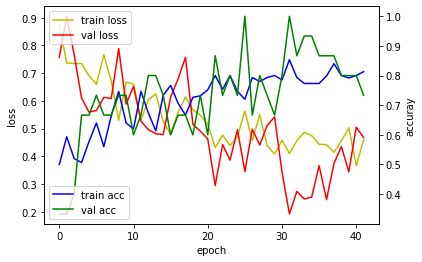

In [32]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

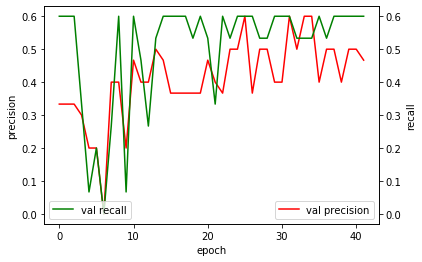

In [33]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['val_precision'], 'r', label='val precision')

acc_ax.plot(hist.history['val_recall'], 'g', label='val recall')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('precision')
acc_ax.set_ylabel('recall')

loss_ax.legend(loc='lower right')
acc_ax.legend(loc='lower left')

plt.show()

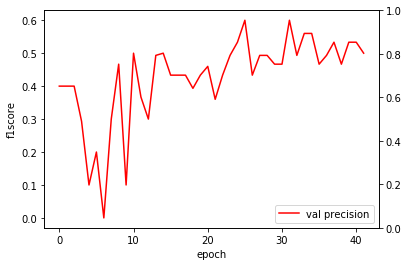

In [34]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['val_f1score'], 'r', label='val precision')



loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('f1score')


loss_ax.legend(loc='lower right')

plt.show()